In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv('../data/train.csv')
stores = pd.read_csv('../data/stores.csv')
oil = pd.read_csv('../data/oil.csv')
holidays = pd.read_csv('../data/holidays_events.csv')

# Convert dates
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

# Create a working copy
df = train.copy()

print(f"Starting shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Starting shape: (3000888, 6)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00


# Calendar Features

In [3]:
# Calendar features from date
df['day_of_week'] = df['date'].dt.dayofweek        # 0=Monday, 6=Sunday
df['day_of_month'] = df['date'].dt.day              # 1-31
df['month'] = df['date'].dt.month                   # 1-12
df['year'] = df['date'].dt.year                     # 2013-2017
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)  # 1-52

# Binary flags
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_month_start'] = (df['day_of_month'] <= 3).astype(int)
df['is_month_end'] = (df['day_of_month'] >= 28).astype(int)

print("Calendar features created:")
print(df[['date', 'day_of_week', 'month', 'is_weekend', 'is_month_start']].head(10))

Calendar features created:
        date  day_of_week  month  is_weekend  is_month_start
0 2013-01-01            1      1           0               1
1 2013-01-01            1      1           0               1
2 2013-01-01            1      1           0               1
3 2013-01-01            1      1           0               1
4 2013-01-01            1      1           0               1
5 2013-01-01            1      1           0               1
6 2013-01-01            1      1           0               1
7 2013-01-01            1      1           0               1
8 2013-01-01            1      1           0               1
9 2013-01-01            1      1           0               1


#  Lag Features

In [4]:
# Sort by store, family, date (critical for correct lag calculation)
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# Group by store-family for lag features
# Each store-family combination is its own time series
df['lag_7'] = df.groupby(['store_nbr', 'family'])['sales'].shift(7)
df['lag_14'] = df.groupby(['store_nbr', 'family'])['sales'].shift(14)
df['lag_28'] = df.groupby(['store_nbr', 'family'])['sales'].shift(28)
df['lag_364'] = df.groupby(['store_nbr', 'family'])['sales'].shift(364)

print("Lag features created:")
print(f"NaNs in lag_7: {df['lag_7'].isna().sum()} ({df['lag_7'].isna().mean()*100:.1f}%)")
print(f"NaNs in lag_364: {df['lag_364'].isna().sum()} ({df['lag_364'].isna().mean()*100:.1f}%)")

Lag features created:
NaNs in lag_7: 12474 (0.4%)
NaNs in lag_364: 648648 (21.6%)


# Rolling Statistics

In [5]:
# Rolling features (shifted by 1 to avoid leakage)
# We shift first, then roll - so we're using days 1-7 ago, not 0-6 ago

def rolling_features(group):
    shifted = group['sales'].shift(1)  # Don't include today
    group['rolling_7_mean'] = shifted.rolling(window=7, min_periods=1).mean()
    group['rolling_7_std'] = shifted.rolling(window=7, min_periods=1).std()
    group['rolling_14_mean'] = shifted.rolling(window=14, min_periods=1).mean()
    group['rolling_28_mean'] = shifted.rolling(window=28, min_periods=1).mean()
    return group

df = df.groupby(['store_nbr', 'family'], group_keys=False).apply(rolling_features)

print("Rolling features created:")
print(df[['date', 'store_nbr', 'family', 'sales', 'rolling_7_mean', 'rolling_7_std']].head(15))

Rolling features created:
         date  store_nbr      family  sales  rolling_7_mean  rolling_7_std
0  2013-01-01          1  AUTOMOTIVE    0.0             NaN            NaN
1  2013-01-02          1  AUTOMOTIVE    2.0        0.000000            NaN
2  2013-01-03          1  AUTOMOTIVE    3.0        1.000000       1.414214
3  2013-01-04          1  AUTOMOTIVE    3.0        1.666667       1.527525
4  2013-01-05          1  AUTOMOTIVE    5.0        2.000000       1.414214
5  2013-01-06          1  AUTOMOTIVE    2.0        2.600000       1.816590
6  2013-01-07          1  AUTOMOTIVE    0.0        2.500000       1.643168
7  2013-01-08          1  AUTOMOTIVE    2.0        2.142857       1.772811
8  2013-01-09          1  AUTOMOTIVE    2.0        2.428571       1.511858
9  2013-01-10          1  AUTOMOTIVE    2.0        2.428571       1.511858
10 2013-01-11          1  AUTOMOTIVE    3.0        2.285714       1.496026
11 2013-01-12          1  AUTOMOTIVE    2.0        2.285714       1.496026

C:\Users\anant\AppData\Local\Temp\ipykernel_22652\683761964.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['store_nbr', 'family'], group_keys=False).apply(rolling_features)


#  Holiday Features

In [6]:
# National holidays (affect all stores)
national_holidays = holidays[holidays['locale'] == 'National'].copy()

# Create holiday lookup
national_holiday_dates = national_holidays['date'].unique()

# Basic holiday flag
df['is_national_holiday'] = df['date'].isin(national_holiday_dates).astype(int)

# Merge holiday type for national holidays
national_holidays_simple = national_holidays[['date', 'type', 'transferred']].drop_duplicates('date')
national_holidays_simple.columns = ['date', 'holiday_type', 'is_transferred']

df = df.merge(national_holidays_simple, on='date', how='left')
df['holiday_type'] = df['holiday_type'].fillna('None')
df['is_transferred'] = df['is_transferred'].fillna(False).astype(int)

# Days to next holiday / days since last holiday
holiday_dates_sorted = sorted(national_holiday_dates)

def days_to_next_holiday(date):
    future = [h for h in holiday_dates_sorted if h > date]
    if future:
        return (future[0] - date).days
    return 999  # No upcoming holiday in data

def days_since_last_holiday(date):
    past = [h for h in holiday_dates_sorted if h <= date]
    if past:
        return (date - past[-1]).days
    return 999  # No past holiday in data

# Apply to unique dates first (faster), then merge
unique_dates = df[['date']].drop_duplicates()
unique_dates['days_to_next_holiday'] = unique_dates['date'].apply(days_to_next_holiday)
unique_dates['days_since_last_holiday'] = unique_dates['date'].apply(days_since_last_holiday)

df = df.merge(unique_dates, on='date', how='left')

print("Holiday features created:")
print(f"National holidays in data: {df['is_national_holiday'].sum() / len(df) * 100:.2f}%")
print(df[df['is_national_holiday'] == 1][['date', 'holiday_type', 'is_transferred']].drop_duplicates().head(10))

C:\Users\anant\AppData\Local\Temp\ipykernel_22652\47471850.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_transferred'] = df['is_transferred'].fillna(False).astype(int)


Holiday features created:
National holidays in data: 8.49%
          date holiday_type  is_transferred
0   2013-01-01      Holiday               0
4   2013-01-05     Work Day               0
11  2013-01-12     Work Day               0
41  2013-02-11      Holiday               0
42  2013-02-12      Holiday               0
118 2013-04-29      Holiday               0
120 2013-05-01      Holiday               0
130 2013-05-11   Additional               0
131 2013-05-12        Event               0
143 2013-05-24      Holiday               0


# Oil Features

In [7]:
# Forward-fill missing oil prices (use last known price)
oil_filled = oil.copy()
oil_filled['dcoilwtico'] = oil_filled['dcoilwtico'].ffill()

# Also backfill for the very first missing values
oil_filled['dcoilwtico'] = oil_filled['dcoilwtico'].bfill()

# Rename for clarity
oil_filled.columns = ['date', 'oil_price']

# Merge with main dataframe
df = df.merge(oil_filled, on='date', how='left')

# Fill any remaining NaNs (dates outside oil data range)
df['oil_price'] = df['oil_price'].ffill().bfill()

# Oil lag and rolling features
oil_daily = oil_filled.set_index('date').sort_index()
oil_daily['oil_lag_7'] = oil_daily['oil_price'].shift(7)
oil_daily['oil_rolling_7_mean'] = oil_daily['oil_price'].shift(1).rolling(7, min_periods=1).mean()
oil_daily = oil_daily.reset_index()

df = df.merge(oil_daily[['date', 'oil_lag_7', 'oil_rolling_7_mean']], on='date', how='left')

print("Oil features created:")
print(df[['date', 'oil_price', 'oil_lag_7', 'oil_rolling_7_mean']].drop_duplicates('date').head(10))

Oil features created:
        date  oil_price  oil_lag_7  oil_rolling_7_mean
0 2013-01-01      93.14        NaN                 NaN
1 2013-01-02      93.14        NaN           93.140000
2 2013-01-03      92.97        NaN           93.140000
3 2013-01-04      93.12        NaN           93.083333
4 2013-01-05      93.12        NaN                 NaN
5 2013-01-06      93.12        NaN                 NaN
6 2013-01-07      93.20        NaN           93.092500
7 2013-01-08      93.21        NaN           93.114000
8 2013-01-09      93.08        NaN           93.130000
9 2013-01-10      93.81      93.14           93.122857


# Store & Family Features

In [8]:
# Merge store metadata
df = df.merge(stores, on='store_nbr', how='left')

print("Store features merged:")
print(df[['store_nbr', 'city', 'state', 'type', 'cluster']].drop_duplicates().head(10))

# Check unique values
print(f"\nStore types: {df['type'].unique()}")
print(f"Store clusters: {sorted(df['cluster'].unique())}")
print(f"Unique families: {df['family'].nunique()}")

Store features merged:
        store_nbr           city                           state type  cluster
0               1          Quito                       Pichincha    D       13
55572           2          Quito                       Pichincha    D       13
111144          3          Quito                       Pichincha    D        8
166716          4          Quito                       Pichincha    D        9
222288          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
277860          6          Quito                       Pichincha    D       13
333432          7          Quito                       Pichincha    D        8
389004          8          Quito                       Pichincha    D        8
444576          9          Quito                       Pichincha    B        6
500148         10          Quito                       Pichincha    C       15

Store types: ['D' 'B' 'C' 'E' 'A']
Store clusters: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.

# Promotion Features

In [9]:
# onpromotion is already in the data
# Create lag features for promotions

df['promo_lag_7'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(7)
df['promo_lag_14'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(14)

print("Promotion features created:")
print(df[['date', 'store_nbr', 'family', 'onpromotion', 'promo_lag_7']].head(10))

Promotion features created:
        date  store_nbr      family  onpromotion  promo_lag_7
0 2013-01-01          1  AUTOMOTIVE            0          NaN
1 2013-01-02          1  AUTOMOTIVE            0          NaN
2 2013-01-03          1  AUTOMOTIVE            0          NaN
3 2013-01-04          1  AUTOMOTIVE            0          NaN
4 2013-01-05          1  AUTOMOTIVE            0          NaN
5 2013-01-06          1  AUTOMOTIVE            0          NaN
6 2013-01-07          1  AUTOMOTIVE            0          NaN
7 2013-01-08          1  AUTOMOTIVE            0          0.0
8 2013-01-09          1  AUTOMOTIVE            0          0.0
9 2013-01-10          1  AUTOMOTIVE            0          0.0


# Handle Missing Values

In [10]:
# Check missing values
print("Missing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Lag features have NaNs for early dates (expected)
# Options:
# 1. Drop rows with NaNs (lose early data)
# 2. Fill with 0 (assumes no prior sales)
# 3. Fill with column median

# For lag features: fill with 0 (reasonable for "no history")
lag_cols = ['lag_7', 'lag_14', 'lag_28', 'lag_364']
for col in lag_cols:
    df[col] = df[col].fillna(0)

# For rolling features: fill with 0
rolling_cols = ['rolling_7_mean', 'rolling_7_std', 'rolling_14_mean', 'rolling_28_mean']
for col in rolling_cols:
    df[col] = df[col].fillna(0)

# For promo lags: fill with 0
df['promo_lag_7'] = df['promo_lag_7'].fillna(0)
df['promo_lag_14'] = df['promo_lag_14'].fillna(0)

# For oil lags: fill with 0 or ffill
df['oil_lag_7'] = df['oil_lag_7'].ffill().bfill()
df['oil_rolling_7_mean'] = df['oil_rolling_7_mean'].ffill().bfill()

# Final missing check
print("\nMissing values after filling:")
missing_after = df.isnull().sum()
print(missing_after[missing_after > 0])

Missing values per column:
lag_7                  12474
lag_14                 24948
lag_28                 49896
lag_364               648648
rolling_7_mean          1782
rolling_7_std           3564
rolling_14_mean         1782
rolling_28_mean         1782
oil_lag_7             869616
oil_rolling_7_mean    858924
promo_lag_7            12474
promo_lag_14           24948
dtype: int64

Missing values after filling:
Series([], dtype: int64)


# Verify No Data Leakage

In [11]:
# Data leakage check for time series:
# A feature has leakage if it uses information from the future

# Pick a specific date and store-family to verify
test_date = pd.Timestamp('2015-06-15')
test_store = 1
test_family = 'GROCERY I'

sample = df[(df['store_nbr'] == test_store) & 
            (df['family'] == test_family) & 
            (df['date'] >= test_date - pd.Timedelta(days=10)) &
            (df['date'] <= test_date + pd.Timedelta(days=3))]

print("Verifying lag_7 calculation:")
print(sample[['date', 'sales', 'lag_7', 'rolling_7_mean']].to_string())

# Manual check:
# For date 2015-06-15, lag_7 should equal sales from 2015-06-08
# rolling_7_mean should be mean of sales from 2015-06-07 to 2015-06-14 (shifted)

Verifying lag_7 calculation:
            date   sales   lag_7  rolling_7_mean
21091 2015-06-05  2747.0  2234.0     2366.000000
21092 2015-06-06  2377.0  2436.0     2439.285714
21093 2015-06-07   832.0  1093.0     2430.857143
21094 2015-06-08  2476.0  2497.0     2393.571429
21095 2015-06-09  2166.0  2554.0     2390.571429
21096 2015-06-10  2718.0  3614.0     2335.142857
21097 2015-06-11  2073.0  2134.0     2207.142857
21098 2015-06-12  2315.0  2747.0     2198.428571
21099 2015-06-13  2341.0  2377.0     2136.714286
21100 2015-06-14  1120.0   832.0     2131.571429
21101 2015-06-15  2428.0  2476.0     2172.714286
21102 2015-06-16  2531.0  2166.0     2165.857143
21103 2015-06-17  2803.0  2718.0     2218.000000
21104 2015-06-18  1900.0  2073.0     2230.142857


# Final Feature Summary & Save

In [12]:
# List all features
print("=" * 50)
print("FINAL FEATURE LIST")
print("=" * 50)

feature_categories = {
    'Identifiers': ['id', 'date', 'store_nbr', 'family'],
    'Target': ['sales'],
    'Calendar': ['day_of_week', 'day_of_month', 'month', 'year', 'week_of_year', 
                 'is_weekend', 'is_month_start', 'is_month_end'],
    'Lag': ['lag_7', 'lag_14', 'lag_28', 'lag_364'],
    'Rolling': ['rolling_7_mean', 'rolling_7_std', 'rolling_14_mean', 'rolling_28_mean'],
    'Holiday': ['is_national_holiday', 'holiday_type', 'is_transferred', 
                'days_to_next_holiday', 'days_since_last_holiday'],
    'Oil': ['oil_price', 'oil_lag_7', 'oil_rolling_7_mean'],
    'Store': ['city', 'state', 'type', 'cluster'],
    'Promotion': ['onpromotion', 'promo_lag_7', 'promo_lag_14']
}

total_features = 0
for category, features in feature_categories.items():
    present = [f for f in features if f in df.columns]
    print(f"\n{category}: {len(present)} features")
    print(f"  {present}")
    if category not in ['Identifiers', 'Target']:
        total_features += len(present)

print(f"\n{'=' * 50}")
print(f"Total engineered features: {total_features}")
print(f"Final dataframe shape: {df.shape}")

# Save to CSV (optional - can be large)
# df.to_csv('../data/train_featured.csv', index=False)

# Or save to parquet (smaller, faster)
df.to_parquet('../data/train_featured.parquet', index=False)
print("\nSaved to ../data/train_featured.parquet")

FINAL FEATURE LIST

Identifiers: 4 features
  ['id', 'date', 'store_nbr', 'family']

Target: 1 features
  ['sales']

Calendar: 8 features
  ['day_of_week', 'day_of_month', 'month', 'year', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end']

Lag: 4 features
  ['lag_7', 'lag_14', 'lag_28', 'lag_364']

Rolling: 4 features
  ['rolling_7_mean', 'rolling_7_std', 'rolling_14_mean', 'rolling_28_mean']

Holiday: 5 features
  ['is_national_holiday', 'holiday_type', 'is_transferred', 'days_to_next_holiday', 'days_since_last_holiday']

Oil: 3 features
  ['oil_price', 'oil_lag_7', 'oil_rolling_7_mean']

Store: 4 features
  ['city', 'state', 'type', 'cluster']

Promotion: 3 features
  ['onpromotion', 'promo_lag_7', 'promo_lag_14']

Total engineered features: 31
Final dataframe shape: (3000888, 36)

Saved to ../data/train_featured.parquet


# Quick Verification Plots

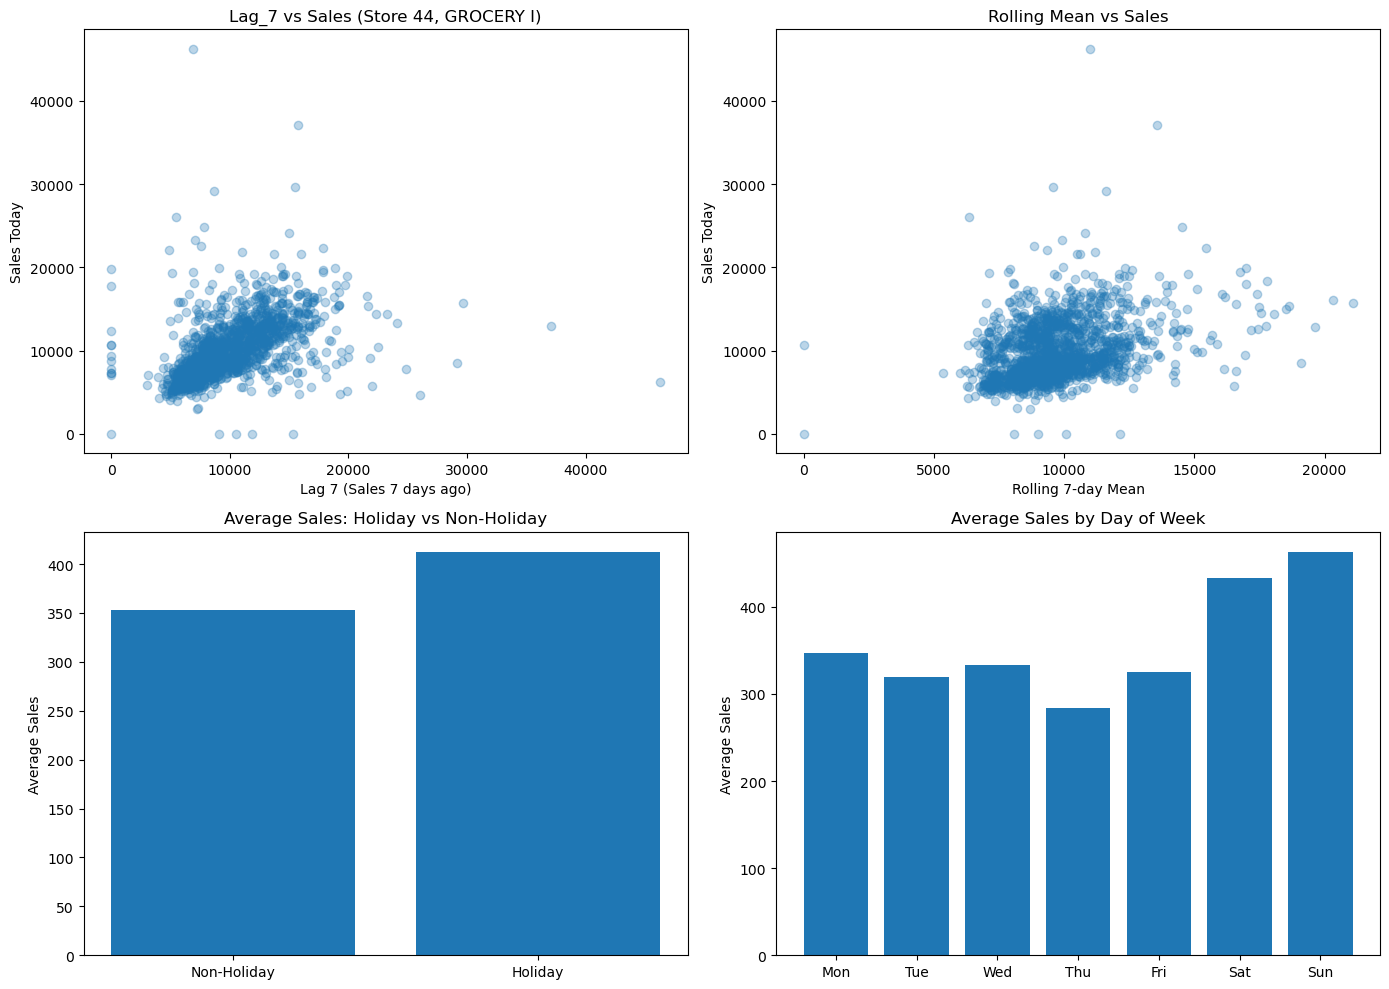

In [13]:
# Verify features make sense
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Lag_7 vs Sales (should be correlated)
sample_store = df[(df['store_nbr'] == 44) & (df['family'] == 'GROCERY I')]
axes[0, 0].scatter(sample_store['lag_7'], sample_store['sales'], alpha=0.3)
axes[0, 0].set_xlabel('Lag 7 (Sales 7 days ago)')
axes[0, 0].set_ylabel('Sales Today')
axes[0, 0].set_title('Lag_7 vs Sales (Store 44, GROCERY I)')

# 2. Rolling mean vs Sales
axes[0, 1].scatter(sample_store['rolling_7_mean'], sample_store['sales'], alpha=0.3)
axes[0, 1].set_xlabel('Rolling 7-day Mean')
axes[0, 1].set_ylabel('Sales Today')
axes[0, 1].set_title('Rolling Mean vs Sales')

# 3. Holiday effect
holiday_sales = df.groupby('is_national_holiday')['sales'].mean()
axes[1, 0].bar(['Non-Holiday', 'Holiday'], holiday_sales.values)
axes[1, 0].set_title('Average Sales: Holiday vs Non-Holiday')
axes[1, 0].set_ylabel('Average Sales')

# 4. Day of week effect
dow_sales = df.groupby('day_of_week')['sales'].mean()
axes[1, 1].bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], dow_sales.values)
axes[1, 1].set_title('Average Sales by Day of Week')
axes[1, 1].set_ylabel('Average Sales')

plt.tight_layout()
plt.show()

# Summary: Feature Engineering

## What We Built

Starting from 6 columns, we engineered **31 features** to help the model understand temporal patterns, external factors, and business context.

---

## Feature Categories

| Category | Features | Purpose |
|----------|----------|---------|
| **Calendar** (8) | day_of_week, day_of_month, month, year, week_of_year, is_weekend, is_month_start, is_month_end | Capture weekly/monthly/yearly seasonality |
| **Lag** (4) | lag_7, lag_14, lag_28, lag_364 | Recent sales history predicts future sales |
| **Rolling** (4) | rolling_7_mean, rolling_7_std, rolling_14_mean, rolling_28_mean | Smoothed trends and volatility |
| **Holiday** (5) | is_national_holiday, holiday_type, is_transferred, days_to_next_holiday, days_since_last_holiday | Holiday shopping effects |
| **Oil** (3) | oil_price, oil_lag_7, oil_rolling_7_mean | Economic indicator (Ecuador depends on oil) |
| **Store** (4) | city, state, type, cluster | Store-level characteristics |
| **Promotion** (3) | onpromotion, promo_lag_7, promo_lag_14 | Promotion effects on sales |

---

## Key Decisions Made

| Decision | Reasoning |
|----------|-----------|
| **Grouped lags by store-family** | Each store-family is its own time series — can't mix lag values across them |
| **Shifted before rolling** | Prevents data leakage — rolling mean uses only past data, not today's sales |
| **Filled lag NaNs with 0** | Early dates have no history — 0 represents "no prior data" |
| **Forward-filled oil prices** | Weekends have no trading — use last known price |
| **National holidays only** | Local/regional holidays affect only specific stores — more complex to implement |

---

## Data Leakage Verification

✅ **Confirmed no leakage:**
- lag_7 for 2015-06-15 = 2476.0
- Sales on 2015-06-08 = 2476.0 ✓
- All features use only past information

---

## Missing Values Handled

| Column Type | Fill Strategy | Rows Affected |
|-------------|---------------|---------------|
| Lag features | Fill with 0 | 12K - 648K |
| Rolling features | Fill with 0 | 1.7K - 3.5K |
| Oil lags | Forward/backward fill | 858K - 869K |
| Promo lags | Fill with 0 | 12K - 25K |

**Final missing values: 0** ✓

---

## Output

- **Final shape:** (3,000,888 rows × 37 columns)
- **Saved to:** `../data/train_featured.parquet`

---

## Next Steps (Day 3)

1. Train/test split using **time-based split** (not random!)
2. Baseline models: Naive forecast, Prophet, ARIMA
3. Establish evaluation metrics: RMSLE, RMSE, MAPE